In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer

fp_loader_configer.select_version("MFP_Specific_Radius")
specific_radius_mfp_loader = fp_loader_configer.fp_loader

import pickle     

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


choosing Specific_Radius_MFP_loader


In [3]:
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [4]:
from inference.inference_utils import choose_model
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [5]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model("C-NMR", include_test_loader = False)


hparams, model , test_loader = choose_model("All-NMR")





Normal
max_radius:  4
loading time: 2.9465575218200684
counting time: 15.151506185531616
finish entropy list


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [6]:
hparams['FP_building_type'].split("_")[-1]

'Normal'

In [7]:
model.device

device(type='cuda', index=0)

In [8]:
max_radius = specific_radius_mfp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [9]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

############################################### compound number: 313##############################################################
Ground Truth NMR
MW filter: [532.71806640625, 799.077099609375]
Chemical name Russuphelol
Ground truth smiles COc1cc(Cl)c(Oc2c(O)cc(Oc3c(Cl)cc(O)cc3Cl)c(OC)c2Oc2c(Cl)cc(O)cc2Cl)c(Cl)c1


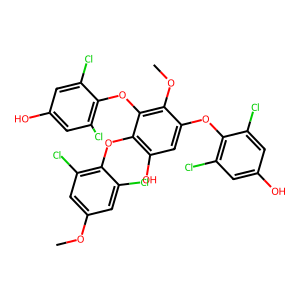

Prediction's cosine similarity to ground truth:  0.7827611565589905
idx is  312
________retival #1, cosine similarity to prediction: 0.782760739326477_________________
SMILES: COc1cc(Cl)c(Oc2c(O)cc(Oc3c(Cl)cc(O)cc3Cl)c(OC)c2Oc2c(Cl)cc(O)cc2Cl)c(Cl)c1
Name Russuphelol
Molecular weight 669.1240000000003


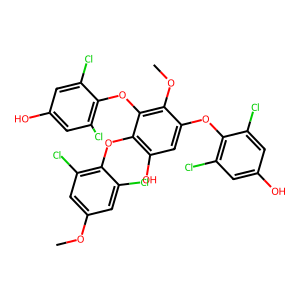

________retival #2, cosine similarity to prediction: 0.7075157165527344_________________
SMILES: COc1c(Br)cc(Br)cc1Oc1c(O)cc(Br)c(Br)c1Br
Name 3,4,5-Tribromo-2-(3,5-Dibromo-2-Methoxyphenoxy)Phenol
Molecular weight 610.7160000000001


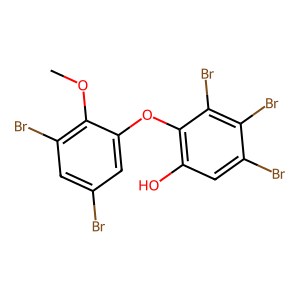

________retival #3, cosine similarity to prediction: 0.707473874092102_________________
SMILES: COc1c(O)ccc2c1ccc1c(-c3c(O)cc(OC)c4c3ccc3c(OC)c(O)ccc34)c(O)cc(OC)c12
Name 4,4',8,8'-Tetramethoxy-1,1'-biphenanthrene-2,2',7,7'-tetrol
Molecular weight 538.5520000000002


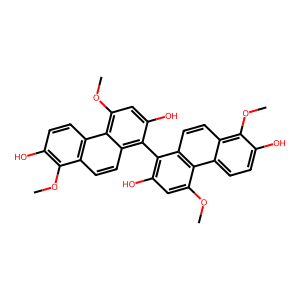

________retival #4, cosine similarity to prediction: 0.7037222385406494_________________
SMILES: COc1cc(OC)c2c(ccc3c(-c4c(O)c(O)cc5c4ccc4cc(OC)cc(OC)c45)c(O)c(O)cc32)c1
Name Volucrin
Molecular weight 538.5520000000004


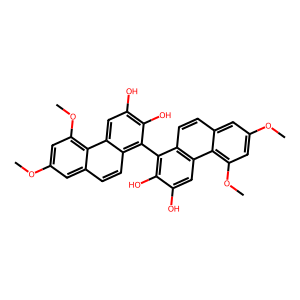

DONE






In [10]:
#### For infrastructure, this is cell can be skipped because i am not sharing my test-loader
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# for which_compound in range(0, 1):
for which_compound in [312 ]:
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    mw_from_input = inputs[0][-1][0].item()
    MW_filter = [mw_from_input*0.8, mw_from_input*1.2]
    print(f"MW filter: {MW_filter}")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=4, filter_by_MW=MW_filter)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    print("idx is ", idx)
    for value, (smile, name, mw , _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        print(f"Molecular weight {mw}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [11]:
pth = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/test_indices_of_full_info_NMRs.pkl"
with open(pth, 'rb') as file:
    test_indices_of_full_info = pickle.load(file)
test_indices_of_full_info.sort()


In [12]:
torch_file_to_loader_idx = {n:i for i, n in enumerate(test_indices_of_full_info)}

In [13]:
torch_file_to_loader_idx["10753.pt"]

312

In [14]:

from inference.inference_utils import convert_hsqc_tensort_to_txt
convert_hsqc_tensort_to_txt("test", 10753)

In [15]:
# '''
# temp feature:
# compute rank-1 on inference set
# '''
# from tqdm import tqdm

# rankingset_data = rankingset_data.to(model.device)
# # for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# accu = [] 
    
# for idx, batch in tqdm(enumerate(test_loader)):
        
#     inputs, extra_info = batch
#     (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
#     # print(inputs.shape, inputs)
#     # print(inputs, smiles_chemical_name)
    
#     # batch[0] = batch[0].to("cuda")
#     # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])

#     inputs = inputs.to(model.device)
#     NMR_type_indicator = NMR_type_indicator[0].to(model.device)
#     pred = model(inputs, NMR_type_indicator)
#     pred=torch.sigmoid(pred) # sigmoid
#     pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)

    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
#     # ground truth
    
#     ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
#     # print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
#     # 
#     i=0
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         # print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
#         # mol = Chem.MolFromSmiles(smile)
#         # # print("retrived FP", retrieved_FP.squeeze().tolist())

#         # print(f"SMILES: {smile}") 
#         # print(f"Name {name}")
#         # img = Draw.MolToImage(mol)
#         # img.show()
#         # i+=1
#         # accu.append(smile == smiles[0])
#         # accu.append(pred_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
#         accu.append(ground_truth_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
#     # if smile == smiles[0]:
#     #     break
    
# print("DONE\n\n\n\n")

# np.mean(accu)        



In [16]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [17]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1

In [18]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


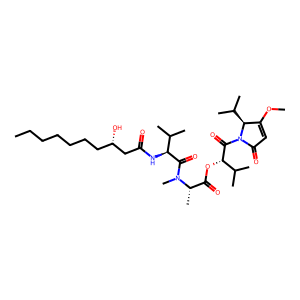

In [19]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img.show()

In [53]:
model.eval()

OptionalInputRankedTransformer(
  (ranker): RankingSet()
  (enc): SignCoordinateEncoder()
  (loss): BCEWithLogitsLoss()
  (NMR_type_embedding): Embedding(4, 784)
  (fc): Linear(in_features=784, out_features=6144, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=784, out_features=784, bias=True)
        )
        (linear1): Linear(in_features=784, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=784, bias=True)
        (norm1): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

____________________________retival #1, cosine similarity: 0.70668625831604_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502

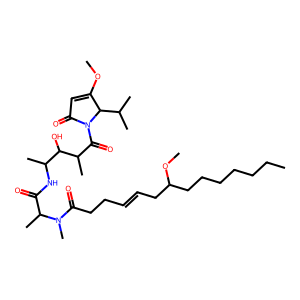

____________________________retival #2, cosine similarity: 0.622870922088623_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.0, 0.0

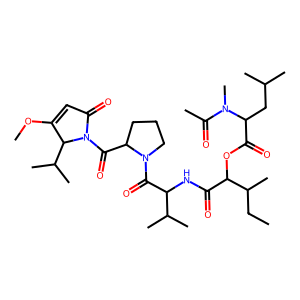

In [20]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7436327338)



________retival #1, cosine similarity to prediction: 0.6816988587379456_________________
________retival's   cosine similarity to ground truth:  0.7066863775253296
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name 934248-75-6


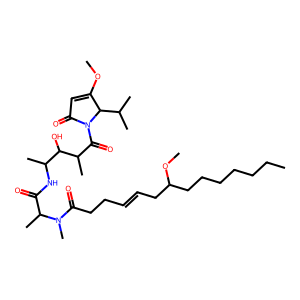

________retival #2, cosine similarity to prediction: 0.622087836265564_________________
________retival's   cosine similarity to ground truth:  0.5888667702674866
SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(O)CC1CC(OC)=CC(=O)O1
Name "(2~{R})-2-[(2~{R})-2-hydroxyhentriacontyl]-4-methoxy-2,3-dihydropyran-6-one"


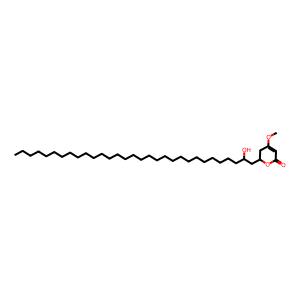

________retival #3, cosine similarity to prediction: 0.6206681132316589_________________
________retival's   cosine similarity to ground truth:  0.5446838736534119
SMILES: CCC(=O)N(C)CCCC(=CCl)CCC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1CC(C)C
Name "~{N}-[4-(chloromethylene)-8-hydroxy-10-(2-isobutyl-3-methoxy-5-oxo-2~{H}-pyrrol-1-yl)-7,9-dimethyl-10-oxo-decyl]-~{N}-methyl-propanamide"


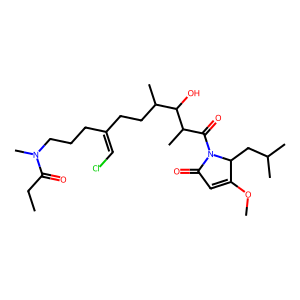

(['CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC',
  'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(O)CC1CC(OC)=CC(=O)O1',
  'CCC(=O)N(C)CCCC(=CCl)CCC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1CC(C)C'],
 ['934248-75-6',
  '"(2~{R})-2-[(2~{R})-2-hydroxyhentriacontyl]-4-methoxy-2,3-dihydropyran-6-one"',
  '"~{N}-[4-(chloromethylene)-8-hydroxy-10-(2-isobutyl-3-methoxy-5-oxo-2~{H}-pyrrol-1-yl)-7,9-dimethyl-10-oxo-decyl]-~{N}-methyl-propanamide"'])

In [56]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "MFP_Specific_Radius", filter_by_MW="from_input")
                   

In [57]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model(model_type)
        max_radius = specific_radius_mfp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [23]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

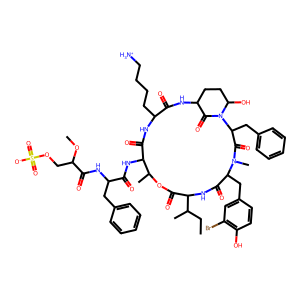

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [24]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

____________________________retival #1, cosine similarity: 0.7940562963485718_____________________________
retrived FP [0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0455

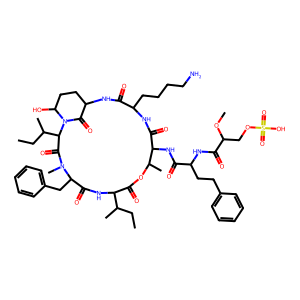

____________________________retival #2, cosine similarity: 0.7912123203277588_____________________________
retrived FP [0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.04476614

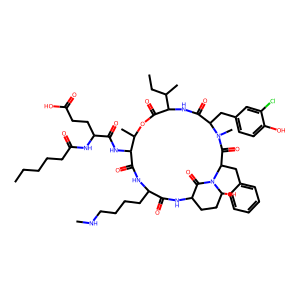

In [25]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7532621622)



________retival #1, cosine similarity to prediction: 0.7879077196121216_________________
________retival's   cosine similarity to ground truth:  0.7804409265518188
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(O)c(Cl)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(CCC(=O)O)NC(C)=O)C(C)OC1=O
Name Cl-Cyanopeptolin W


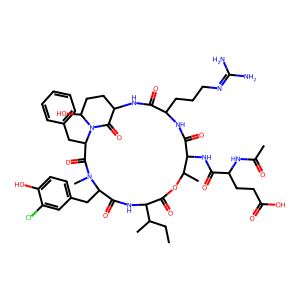

________retival #2, cosine similarity to prediction: 0.787746787071228_________________
________retival's   cosine similarity to ground truth:  0.7893338203430176
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(O)c(Cl)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(CCC(N)=O)NC(C)=O)C(C)OC1=O
Name HA983


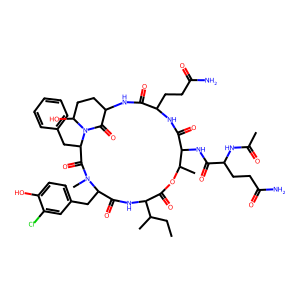

________retival #3, cosine similarity to prediction: 0.7828134298324585_________________
________retival's   cosine similarity to ground truth:  0.7912124991416931
SMILES: CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(CCCCNC)C(=O)NC2CCC(O)N(C2=O)C(Cc2ccccc2)C(=O)N(C)C(Cc2ccc(O)c(Cl)c2)C(=O)NC(C(C)CC)C(=O)OC1C
Name "5-[[2-benzyl-5-[(3-chloro-4-hydroxy-phenyl)methyl]-21-hydroxy-4,11-dimethyl-15-[4-(methylamino)butyl]-3,6,9,13,16,22-hexaoxo-8-~{sec}-butyl-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-4-(hexanoylamino)-5-oxo-pentanoic acid"


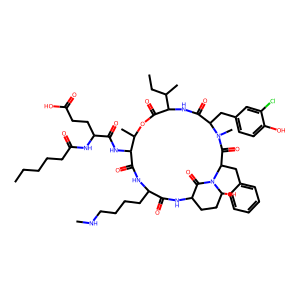

(['CCC(C)C1NC(=O)C(Cc2ccc(O)c(Cl)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(CCC(=O)O)NC(C)=O)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccc(O)c(Cl)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(CCC(N)=O)NC(C)=O)C(C)OC1=O',
  'CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(CCCCNC)C(=O)NC2CCC(O)N(C2=O)C(Cc2ccccc2)C(=O)N(C)C(Cc2ccc(O)c(Cl)c2)C(=O)NC(C(C)CC)C(=O)OC1C'],
 ['Cl-Cyanopeptolin W',
  'HA983',
  '"5-[[2-benzyl-5-[(3-chloro-4-hydroxy-phenyl)methyl]-21-hydroxy-4,11-dimethyl-15-[4-(methylamino)butyl]-3,6,9,13,16,22-hexaoxo-8-~{sec}-butyl-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-4-(hexanoylamino)-5-oxo-pentanoic acid"'])

In [59]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [27]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




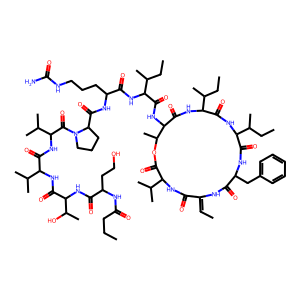

(['Oligopeptides'], False)

In [60]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

____________________________retival #1, cosine similarity: 0.9056555032730103_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0

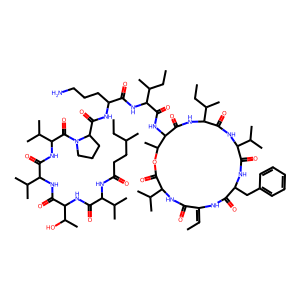

In [29]:
newCompoundB_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7731454968)



________retival #1, cosine similarity to prediction: 0.8204866051673889_________________
________retival's   cosine similarity to ground truth:  0.9023136496543884
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


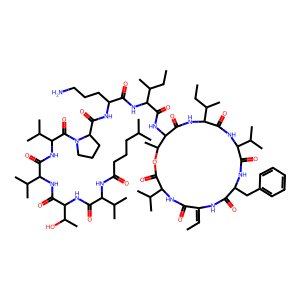

________retival #2, cosine similarity to prediction: 0.8173666000366211_________________
________retival's   cosine similarity to ground truth:  0.8949275612831116
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide U


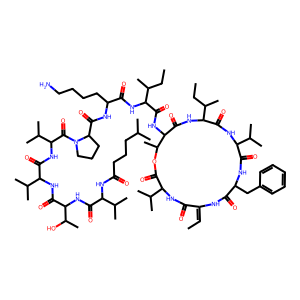

________retival #3, cosine similarity to prediction: 0.8164448738098145_________________
________retival's   cosine similarity to ground truth:  0.9056560397148132
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


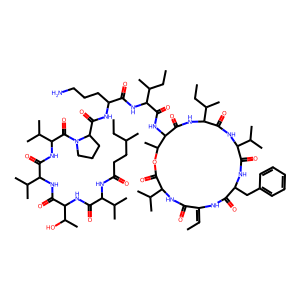

________retival #4, cosine similarity to prediction: 0.8154317140579224_________________
________retival's   cosine similarity to ground truth:  0.8981876969337463
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 5-OHKF


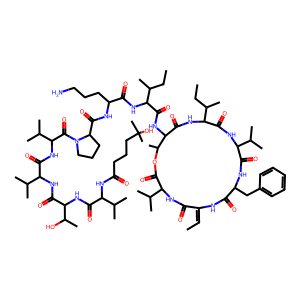

________retival #5, cosine similarity to prediction: 0.8112556338310242_________________
________retival's   cosine similarity to ground truth:  0.8869532346725464
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


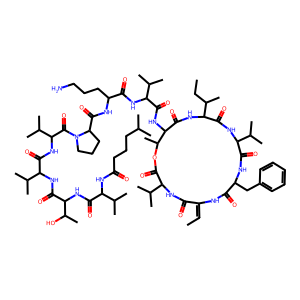

________retival #6, cosine similarity to prediction: 0.7975438237190247_________________
________retival's   cosine similarity to ground truth:  0.9023136496543884
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R})-1-[[(6~{Z},9~{S},12~{R},15~{R},18~{R})-9-benzyl-6-ethylidene-3-isopropyl-19-methyl-2,5,8,11,14,17-hexaoxo-12,15-di~{sec}-butyl-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-3-methyl-butyl]carbamoyl]butyl]-1-[2-[[2-[[(2~{S})-2-[[2-(butanoylamino)-3-methyl-butanoyl]amino]-3-hydroxy-butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


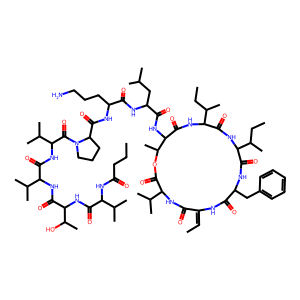

________retival #7, cosine similarity to prediction: 0.7957172989845276_________________
________retival's   cosine similarity to ground truth:  0.8331984281539917
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)CCCC(O)CC(C)C)C(C)C)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide S


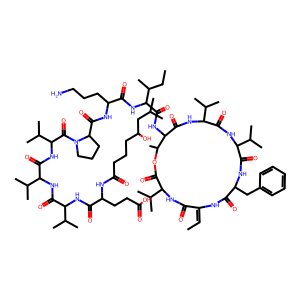

________retival #8, cosine similarity to prediction: 0.7951532602310181_________________
________retival's   cosine similarity to ground truth:  0.8312613368034363
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)CCCCCC(C)C)C(C)C)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 44559124


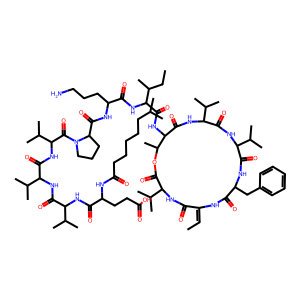

________retival #9, cosine similarity to prediction: 0.7892994284629822_________________
________retival's   cosine similarity to ground truth:  0.8558481931686401
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)CC(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},9~{S},12~{R},15~{R},19~{S},20~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-20-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacycloicos-19-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-(5-methylhexanoylamino)butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


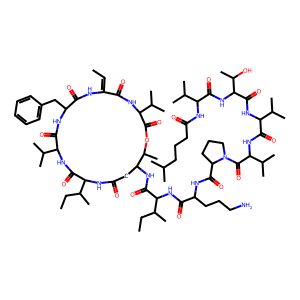

________retival #10, cosine similarity to prediction: 0.7737270593643188_________________
________retival's   cosine similarity to ground truth:  0.8620704412460327
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)C=C(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R})-1-[[(6~{Z},9~{S},12~{R},15~{R},18~{R})-9-benzyl-6-ethylidene-3-isopropyl-19-methyl-2,5,8,11,14,17-hexaoxo-12,15-di~{sec}-butyl-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-3-methyl-butyl]carbamoyl]butyl]-1-[2-[[2-[[(2~{S})-3-hydroxy-2-[[3-methyl-2-(3-methylbut-2-enoylamino)butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


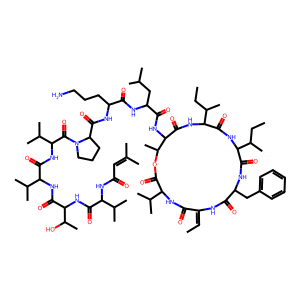

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O

In [61]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=10, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7094237208)



________retival #1, cosine similarity to prediction: 0.7551437020301819_________________
________retival's   cosine similarity to ground truth:  0.9056560397148132
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrol

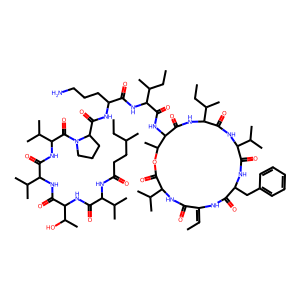

________retival #2, cosine similarity to prediction: 0.7517045736312866_________________
________retival's   cosine similarity to ground truth:  0.9023136496543884
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


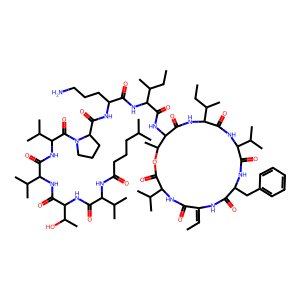

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"',
  '9898671'])

In [62]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [32]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [33]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)